<a href="https://colab.research.google.com/github/bajpaidivyanshi2005-sketch/OIBSIP/blob/main/LEVEL_2_TASK_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Missing Libs**

In [ ]:
!pip install squarify wordcloud textblob plotly scikit-learn matplotlib seaborn
!python -m textblob.download_corpora


  Using cached squarify-0.4.4-py3-none-any.whl.metadata (600 bytes)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
!pip install -U pip setuptools wheel
!pip install textblob --no-cache-dir


In [ ]:
!pip install textblob
!python -m textblob.download_corpora


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


# **Imports + upload files**

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
import re
from google.colab import files

sns.set(style="whitegrid", palette="muted", font_scale=1.0)
plt.rcParams['figure.figsize'] = (10,6)

# Upload files (run and choose apps.csv and user_reviews.csv)
uploaded = files.upload()
apps = pd.read_csv("apps.csv")
reviews = pd.read_csv("user_reviews.csv")


Saving apps.csv to apps (1).csv


# **Quick look & cleanup basics**

In [ ]:
apps.head()
apps.info()
reviews.head()
reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #

Drop stray index column, unify column names

In [ ]:
# drop common auto index column if present
if 'Unnamed: 0' in apps.columns:
    apps = apps.drop(columns=['Unnamed: 0'])

# unify column names (if different)
apps.columns = [c.strip() for c in apps.columns]
reviews.columns = [c.strip() for c in reviews.columns]

# quick shapes
print("apps:", apps.shape, "reviews:", reviews.shape)

apps: (9659, 13) reviews: (64295, 5)


# **Robust cleaning / type conversions**

In [ ]:
# Convert Price -> float
apps['Price'] = apps['Price'].astype(str).replace('[\$,]', '', regex=True)
apps['Price'] = apps['Price'].replace('Free', '0', regex=False)
apps['Price'] = pd.to_numeric(apps['Price'], errors='coerce').fillna(0.0)

# Clean Installs -> int
apps['Installs'] = apps['Installs'].astype(str).str.replace('[+,]', '', regex=True)
apps['Installs'] = pd.to_numeric(apps['Installs'], errors='coerce').fillna(0).astype(int)

# Reviews -> numeric
apps['Reviews'] = pd.to_numeric(apps['Reviews'], errors='coerce').fillna(0).astype(int)

# Rating -> float
apps['Rating'] = pd.to_numeric(apps['Rating'], errors='coerce')

# Size -> convert to MB (helper)
def size_to_mb(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s in ['Varies with device', 'Varies with device.']:
        return np.nan
    if s.endswith('M'):
        try: return float(s[:-1])
        except: return np.nan
    if s.endswith('k'):
        try: return float(s[:-1]) / 1024
        except: return np.nan
    try:
        return float(s)
    except:
        return np.nan

apps['Size_MB'] = apps['Size'].apply(size_to_mb)

# Last Updated -> datetime
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'], errors='coerce')

# Drop duplicate app rows by App name (keep first)
apps = apps.drop_duplicates(subset='App').reset_index(drop=True)


# **Basic EDA / distributions**

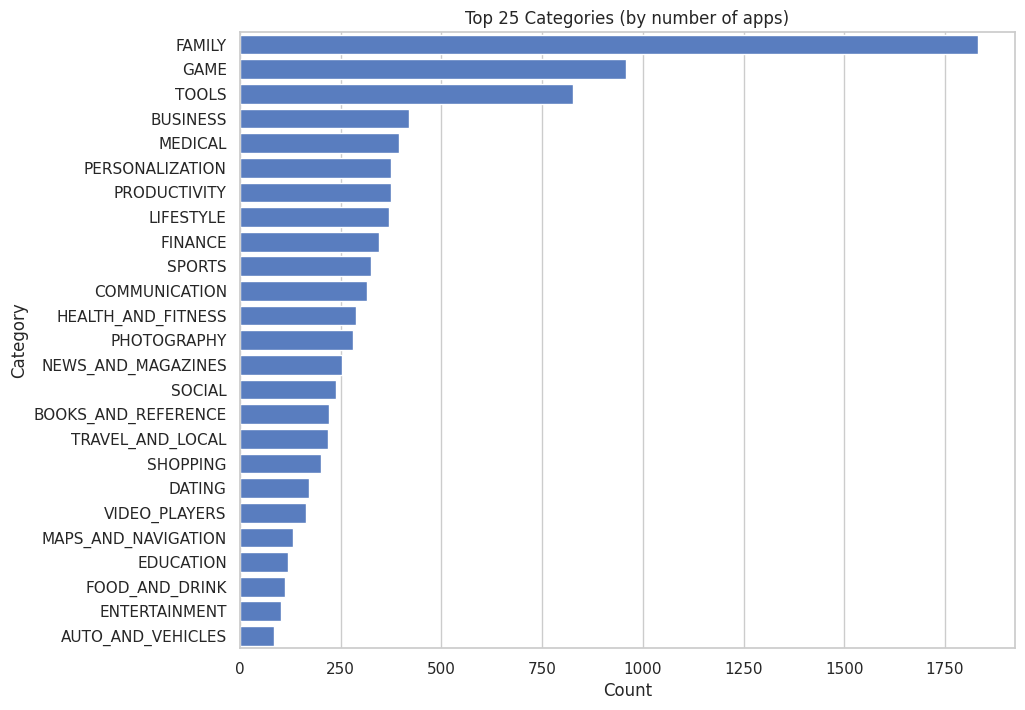

In [ ]:
# Top categories
apps['Category'].value_counts().head(20)

# Plot: number of apps by category
plt.figure(figsize=(10,8))
topcats = apps['Category'].value_counts().nlargest(25).index
sns.countplot(y='Category', data=apps[apps['Category'].isin(topcats)], order=topcats)
plt.title("Top 25 Categories (by number of apps)")
plt.xlabel("Count")
plt.show()

# **Top apps by installs & rating**

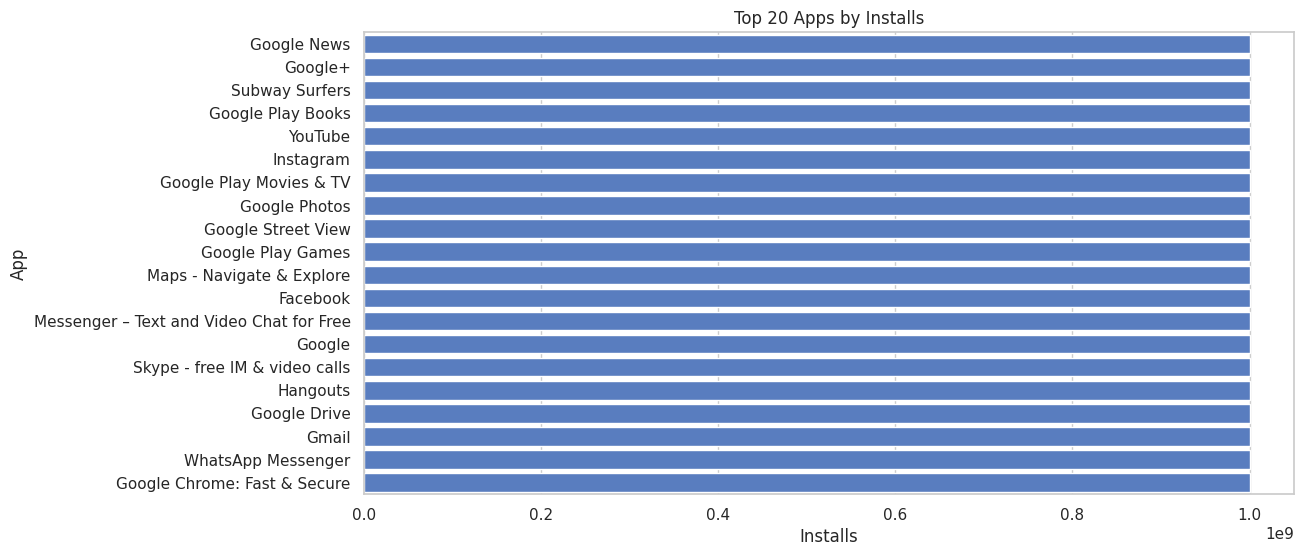

,App,Category,Rating,Installs,Reviews
64,DMV Permit Practice Test 2018 Edition,AUTO_AND_VEHICLES,4.9,100000,6090
9352,FK Željezničar,SPORTS,4.9,10000,1420
9084,FC Porto,SPORTS,4.9,100000,15883
585,"Learn Japanese, Korean, Chinese Offline & Free",EDUCATION,4.9,1000000,133136
1102,Down Dog: Great Yoga Anywhere,HEALTH_AND_FITNESS,4.9,500000,28945
4032,Solitaire: Decked Out Ad Free,GAME,4.9,500000,37302
1078,StrongLifts 5x5 Workout Gym Log & Personal Tra...,HEALTH_AND_FITNESS,4.9,1000000,66791
8859,Eddsworld Amino,SOCIAL,4.9,10000,3071
8490,JW Library,BOOKS_AND_REFERENCE,4.9,10000000,922752
177,eBoox new: Reader for fb2 epub zip books,BOOKS_AND_REFERENCE,4.9,50000,2739


In [ ]:
top_installs = apps.sort_values('Installs', ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x='Installs', y='App', data=top_installs)
plt.title("Top 20 Apps by Installs")
plt.show()

# Top rated apps (min reviews filter)
top_rated = apps[apps['Reviews']>1000].sort_values('Rating', ascending=False).head(20)
top_rated[['App','Category','Rating','Installs','Reviews']].head(10)


# **Rating distribution + installs vs rating scatter (log scale)**

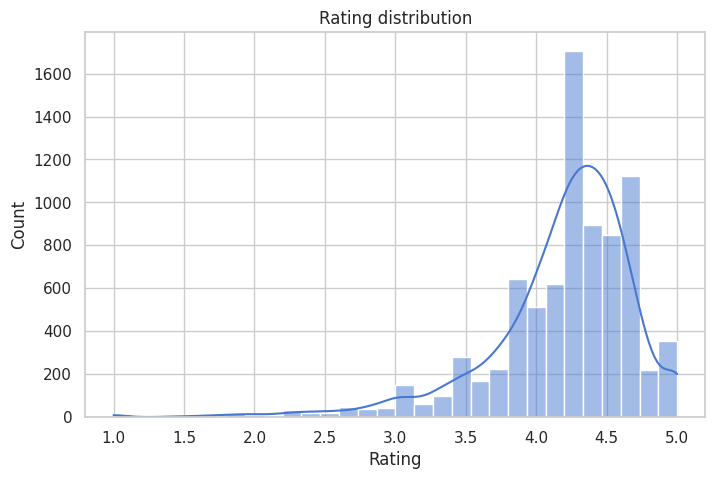

In [ ]:
# Rating histogram + KDE
plt.figure(figsize=(8,5))
sns.histplot(apps['Rating'].dropna(), bins=30, kde=True)
plt.title("Rating distribution")
plt.show()

# Scatter: Rating vs Installs (log y)
fig = px.scatter(apps, x='Rating', y='Installs', size='Reviews', color='Category',
                 log_y=True, hover_name='App', title='Rating vs Installs (log scale)')
fig.show()


# **Boxplots and violin plots by category (top categories)**

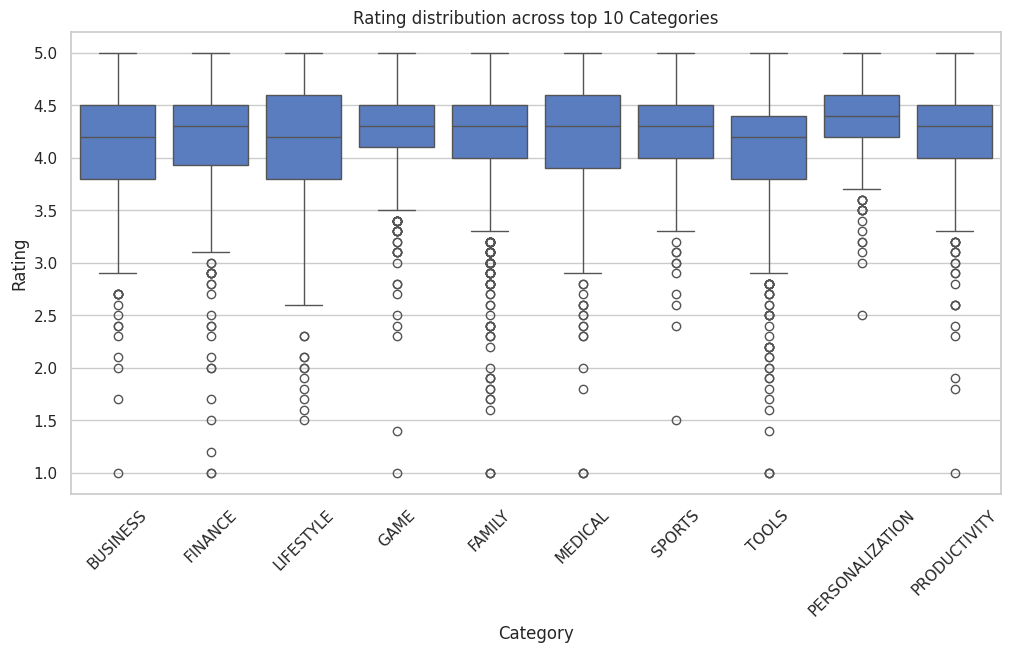

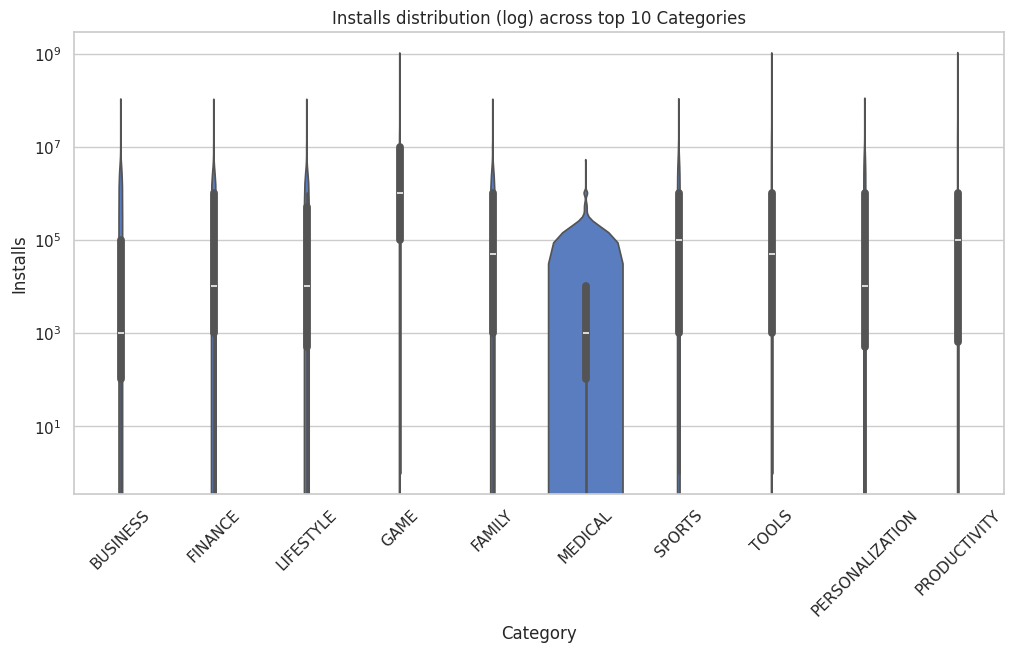

In [ ]:
top10 = apps['Category'].value_counts().nlargest(10).index
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='Rating', data=apps[apps['Category'].isin(top10)])
plt.xticks(rotation=45)
plt.title("Rating distribution across top 10 Categories")
plt.show()

plt.figure(figsize=(12,6))
sns.violinplot(x='Category', y='Installs', data=apps[apps['Category'].isin(top10)])
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Installs distribution (log) across top 10 Categories")
plt.show()


# **Correlation heatmap (numeric features)**

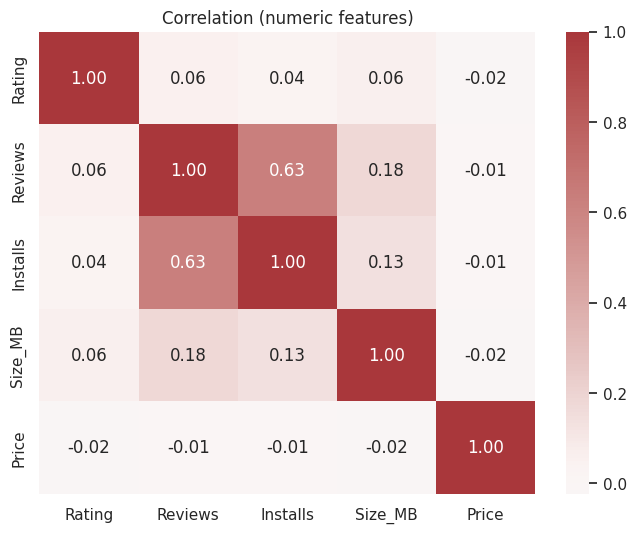

In [ ]:
num = apps[['Rating','Reviews','Installs','Size_MB','Price']].copy()
num = num.apply(pd.to_numeric, errors='coerce')
corr = num.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation (numeric features)")
plt.show()


# **Pivot heatmap: avg rating by Category vs Content Rating**

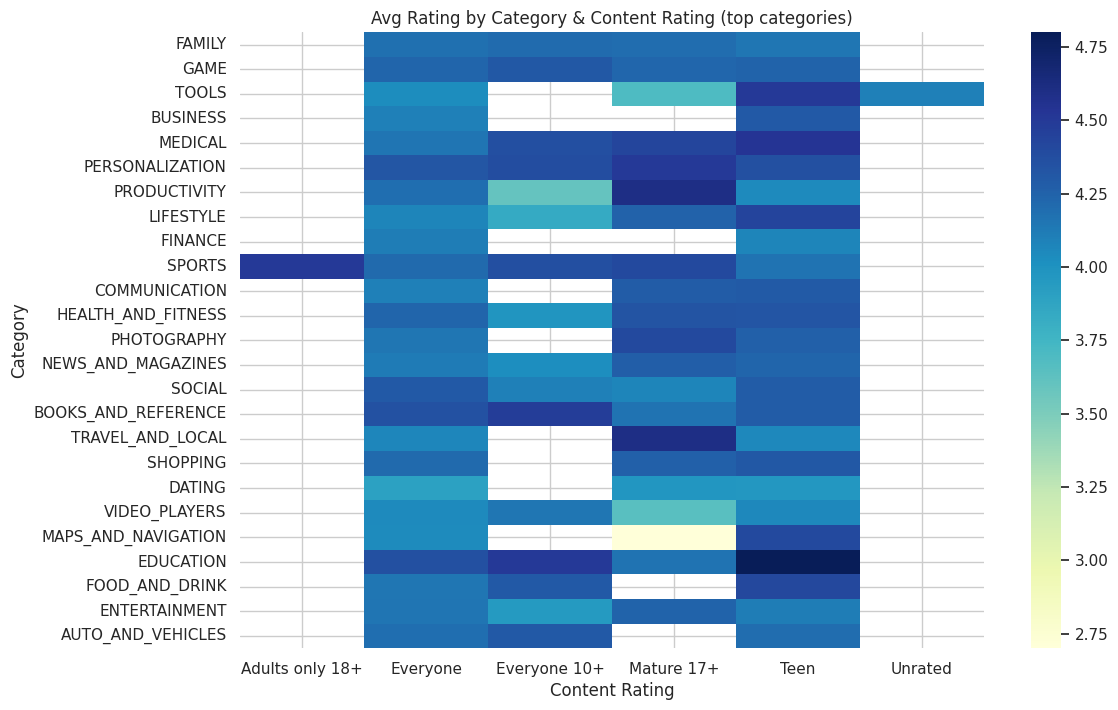

In [ ]:
pivot = apps.pivot_table(index='Category', columns='Content Rating', values='Rating', aggfunc='mean')
pivot = pivot.loc[topcats]  # show top categories
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=False, cmap='YlGnBu')
plt.title("Avg Rating by Category & Content Rating (top categories)")
plt.show()


# **Treemap / Sunburst of installs by Category (interactive)**

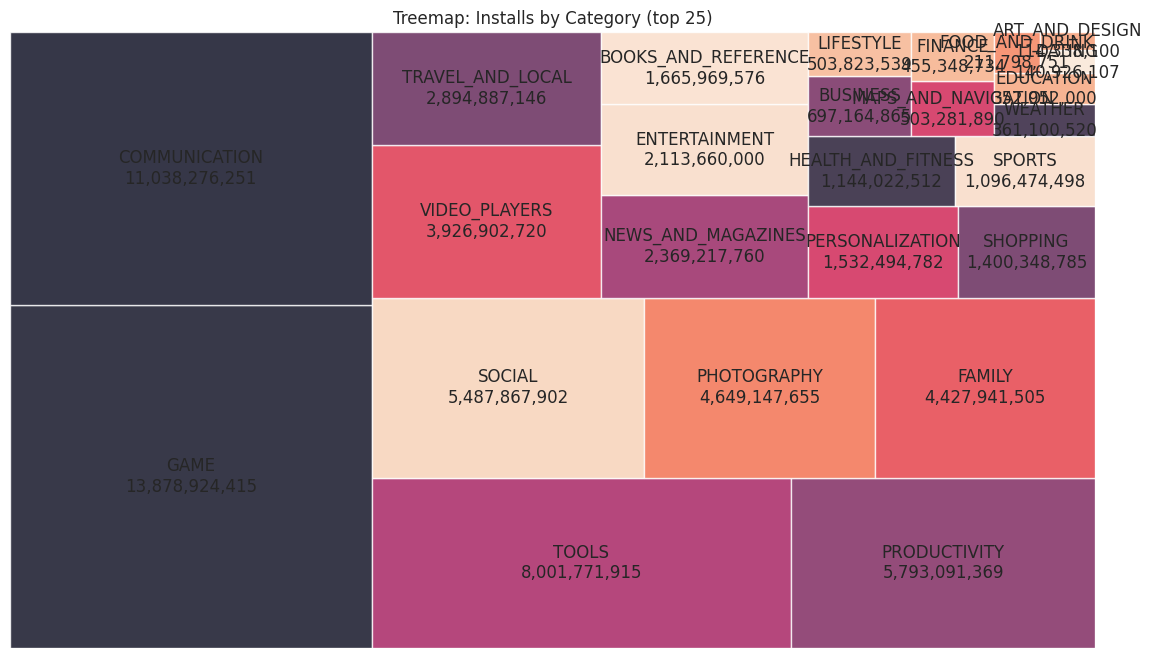

In [ ]:
# Treemap using squarify (static)
cat_installs = apps.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(25)
plt.figure(figsize=(14,8))
squarify.plot(sizes=cat_installs.values, label=[f"{i}\n{v:,}" for i,v in zip(cat_installs.index,cat_installs.values)], alpha=.8 )
plt.axis('off')
plt.title("Treemap: Installs by Category (top 25)")
plt.show()

# Plotly sunburst (interactive)
fig = px.sunburst(apps, path=['Category','Genres'], values='Installs', title='Installs by Category and Genre (sunburst)')
fig.show()


# **Merge reviews & sentiment overview**

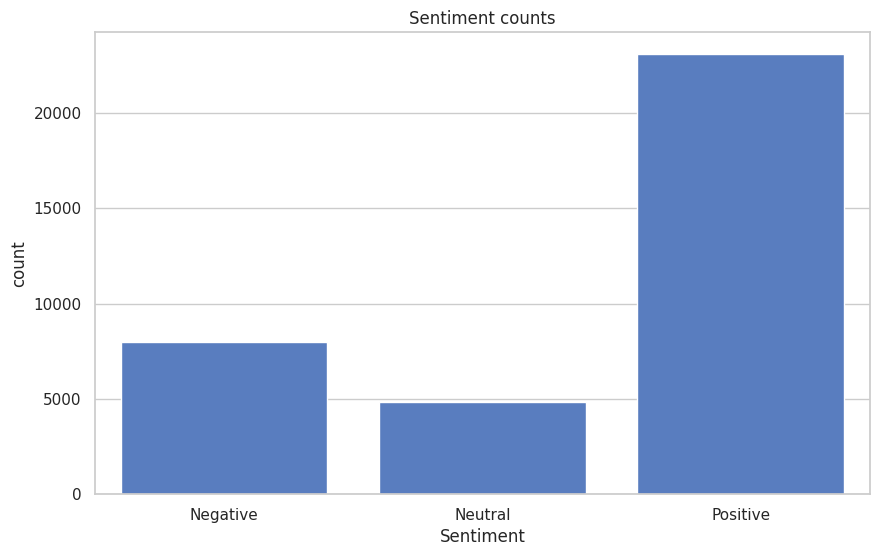

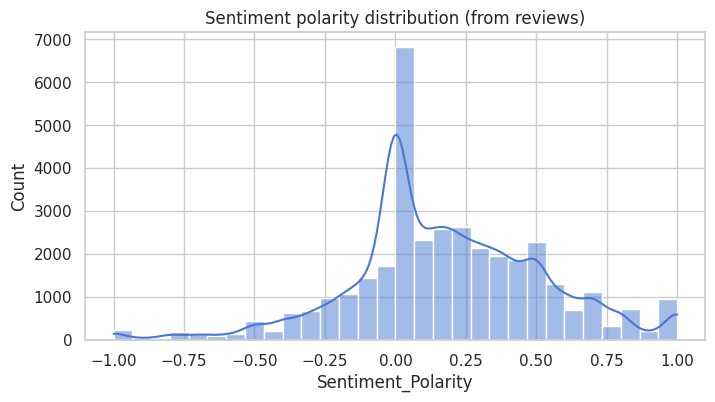

In [ ]:
# merge datasets
merged = pd.merge(apps[['App','Category','Rating','Installs','Reviews','Price','Size_MB','Last Updated']],
                  reviews[['App','Translated_Review','Sentiment','Sentiment_Polarity','Sentiment_Subjectivity']],
                  on='App', how='left')

# Sentiment distribution (if Sentiment column exists)
if 'Sentiment' in merged.columns:
    sns.countplot(x='Sentiment', data=merged)
    plt.title("Sentiment counts")
    plt.show()

# Polarity distribution
plt.figure(figsize=(8,4))
sns.histplot(merged['Sentiment_Polarity'].dropna(), bins=30, kde=True)
plt.title("Sentiment polarity distribution (from reviews)")
plt.show()


# **Wordclouds (all reviews, positive, negative)**

In [ ]:
import pandas as pd

# Load CSV files
apps_df = pd.read_csv("apps.csv")
apps_dup_df = pd.read_csv("apps (1).csv")
reviews_df = pd.read_csv("user_reviews.csv")

# Check first few rows
print(apps_df.head())
print(reviews_df.head())


   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size     Installs  Type Price  \
0  ART_AND_DESIGN     4.1      159  19.0      10,000+  Free     0   
1  ART_AND_DESIGN     3.9      967  14.0     500,000+  Free     0   
2  ART_AND_DESIGN     4.7    87510   8.7   5,000,000+  Free     0   
3  ART_AND_DESIGN     4.5   215644  25.0  50,000,000+  Free     0   
4  ART_AND_DESIGN     4.3      967   2.8     100,000+  Free     0   

  Content Rating                     Genres      Last Updated  \
0       Everyone               Art & Design   January 7, 2018   
1       Everyone  Art & Design;Pretend Play  J

In [ ]:
import pandas as pd
from textblob import TextBlob

# Load your data into a DataFrame named 'df'
# The correct filename is 'user_reviews.csv' as shown in your file explorer
df = pd.read_csv('user_reviews.csv')

# Now you can run your sentiment analysis code
df['TB_Polarity'] = df['Translated_Review'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

# You can now print the first few rows to check if it worked
print(df.head())

                     App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  TB_Polarity  
0  Positive                1.00                0.533333         1.00  
1  Positive                0.25                0.288462         0.25  
2       NaN                 NaN                     NaN         0.00  
3  Positive                0.40                0.875000         0.40  
4  Positive                1.00                0.300000         1.00  


In [ ]:
import pandas as pd
from textblob import TextBlob

# Load your data into a DataFrame named 'df'
df = pd.read_csv('user_reviews.csv')

# --- Add this line to check your column names ---
print(df.columns)
# -----------------------------------------------

# The following line will fail if 'Translated_Review' does not exist
df['TB_Polarity'] = df['Translated_Review'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

print(df.head())

Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'],
      dtype='object')
                     App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  TB_Polarity  
0  Positive                1.00                0.533333         1.00  
1  Positive                0.25                0.288462         0.25  
2       NaN                 NaN                     NaN         0.00  
3  Positive                0.40                0.875000         0.40  
4  Positive                1.00             

In [ ]:
from textblob import TextBlob

df['TB_Polarity'] = df['Translated_Review'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)


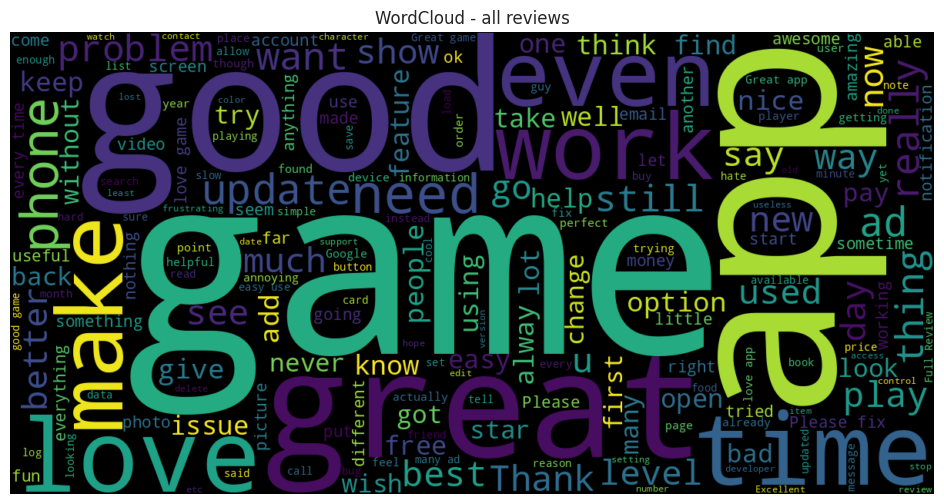

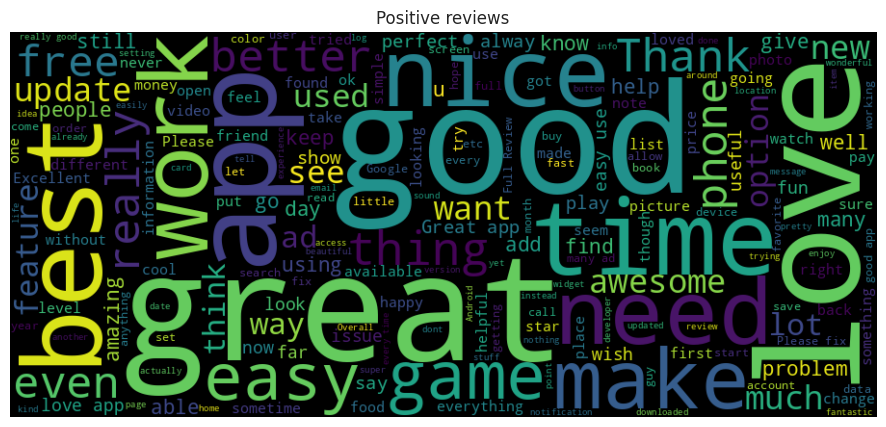

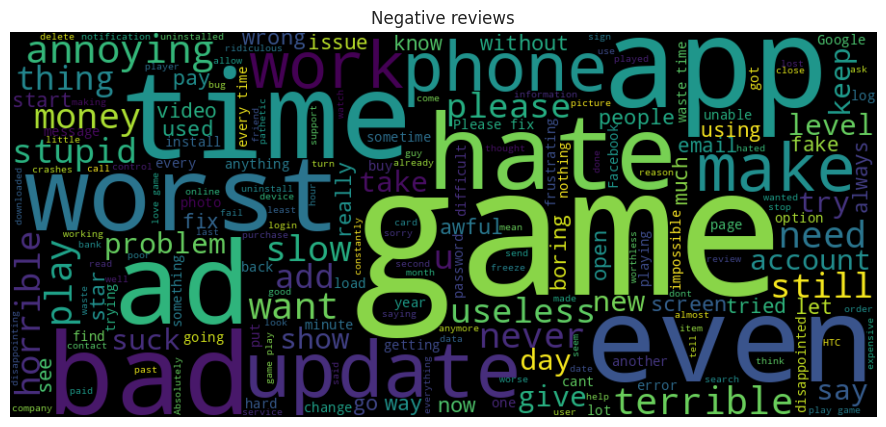

In [ ]:
# --- WordCloud and matplotlib imports must be done first ---
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is the DataFrame loaded with 'user_reviews.csv'
# and the 'TB_Polarity' and 'Translated_Review' columns have been created.

# Combine all review text
all_text = " ".join(df['Translated_Review'].dropna().astype(str).tolist())
stopwords = set(STOPWORDS)

if all_text:
    wc = WordCloud(width=1200, height=600, stopwords=stopwords, collocations=True).generate(all_text)
    plt.figure(figsize=(15, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title("WordCloud - all reviews")
    plt.show()

# Positive reviews > 0.2 polarity
pos_reviews_df = df[df['TB_Polarity'] > 0.2]
pos_text = " ".join(pos_reviews_df['Translated_Review'].dropna().astype(str).tolist())

if pos_text:
    wc_pos = WordCloud(width=900, height=400, stopwords=stopwords).generate(pos_text)
    plt.figure(figsize=(12, 5))
    plt.imshow(wc_pos, interpolation="bilinear")
    plt.axis('off')
    plt.title("Positive reviews")
    plt.show()


# Negative reviews < -0.2 polarity
neg_reviews_df = df[df['TB_Polarity'] < -0.2]
neg_text = " ".join(neg_reviews_df['Translated_Review'].dropna().astype(str).tolist())

if neg_text:
    wc_neg = WordCloud(width=900, height=400, stopwords=stopwords).generate(neg_text)
    plt.figure(figsize=(12, 5))
    plt.imshow(wc_neg, interpolation="bilinear")
    plt.axis('off')
    plt.title("Negative reviews")
    plt.show()


# **Top n-grams for positive & negative reviews**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, ngram_range=(1,1), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# The DataFrame is named 'df', not 'merged'
# Make sure to run this after creating the 'TB_Polarity' column.

pos_corpus = df[df['TB_Polarity'] > 0.2]['Translated_Review'].dropna().astype(str).tolist()
neg_corpus = df[df['TB_Polarity'] < -0.2]['Translated_Review'].dropna().astype(str).tolist()

print("Top positive unigrams:", top_ngrams(pos_corpus, (1,1), 15))
print("Top negative unigrams:", top_ngrams(neg_corpus, (1,1), 15))

Top positive unigrams: [('good', np.int64(3726)), ('great', np.int64(3605)), ('love', np.int64(3228)), ('app', np.int64(2681)), ('like', np.int64(2182)), ('easy', np.int64(1704)), ('best', np.int64(1664)), ('time', np.int64(1462)), ('really', np.int64(1330)), ('game', np.int64(1290)), ('nice', np.int64(1253)), ('better', np.int64(988)), ('free', np.int64(942)), ('ve', np.int64(834)), ('way', np.int64(829))]
Top negative unigrams: [('game', np.int64(1271)), ('time', np.int64(440)), ('like', np.int64(380)), ('app', np.int64(379)), ('bad', np.int64(374)), ('ads', np.int64(323)), ('worst', np.int64(315)), ('hate', np.int64(312)), ('play', np.int64(298)), ('phone', np.int64(252)), ('annoying', np.int64(249)), ('update', np.int64(227)), ('fix', np.int64(216)), ('work', np.int64(210)), ('terrible', np.int64(200))]


# **Time series: apps updated per year**

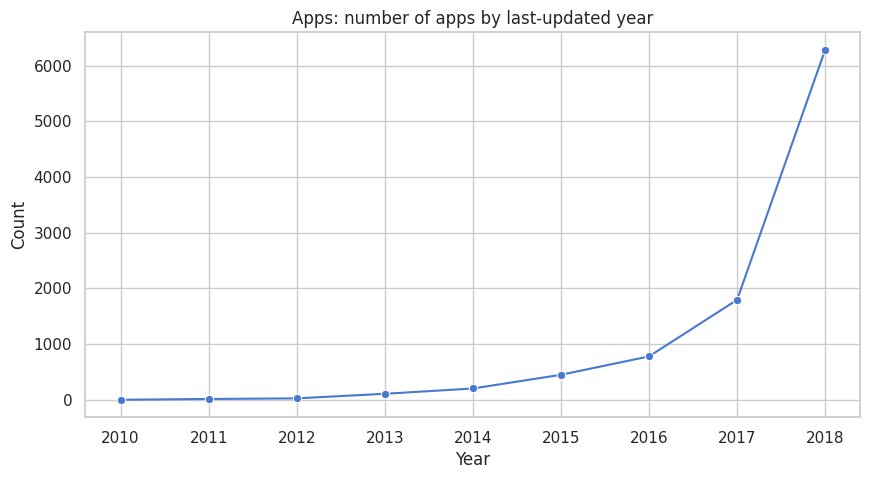

In [ ]:
apps['year_updated'] = apps['Last Updated'].dt.year
year_counts = apps['year_updated'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title("Apps: number of apps by last-updated year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


# **Paid vs Free analysis**

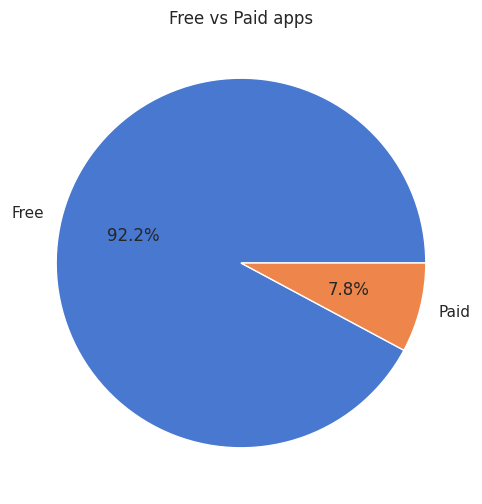

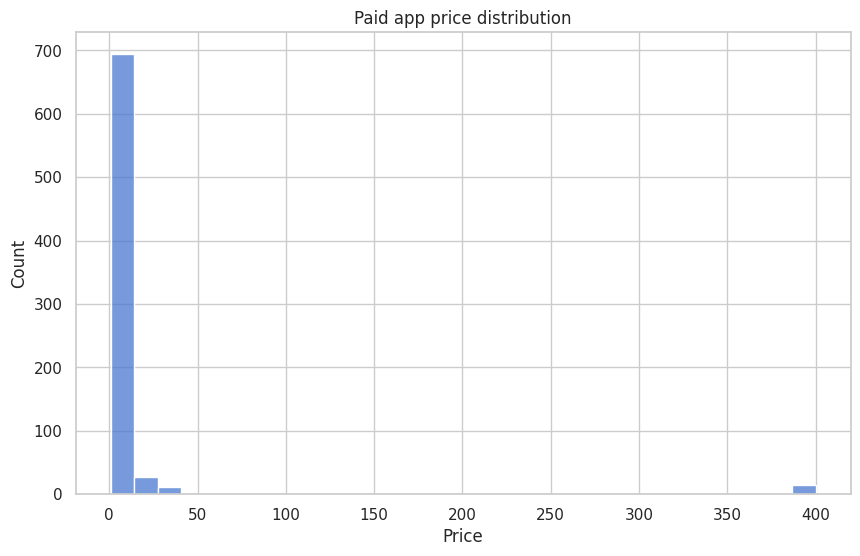

In [ ]:
# Type column usually 'Free' or 'Paid'
if 'Type' in apps.columns:
    v = apps['Type'].value_counts()
    v.plot(kind='pie', autopct='%1.1f%%', ylabel='')
    plt.title("Free vs Paid apps")
    plt.show()

    # Price distribution of paid apps
    paid = apps[apps['Price']>0]
    if not paid.empty:
        sns.histplot(paid['Price'], bins=30)
        plt.title("Paid app price distribution")
        plt.show()


# **Clustering (PCA + KMeans) — group similar apps**

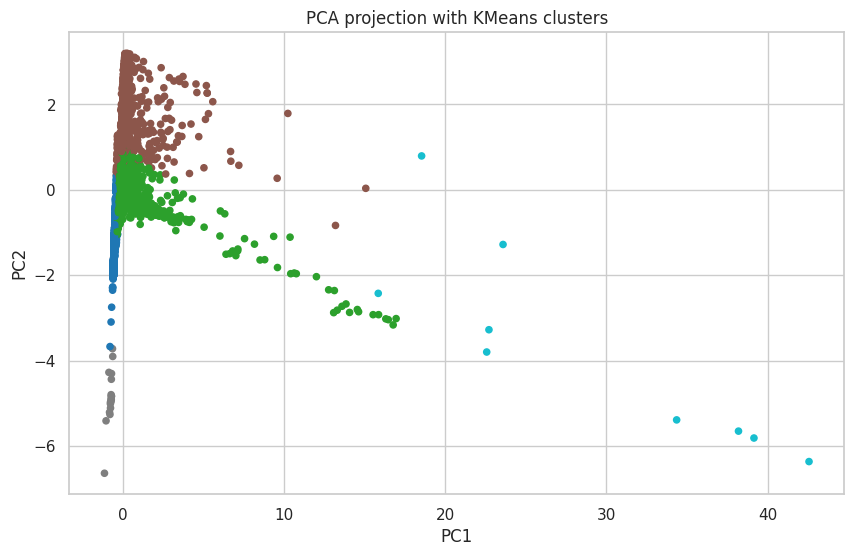

In [ ]:
# feature selection and cleanup
X = apps[['Rating','Reviews','Installs','Size_MB','Price']].copy()
X = X.fillna(0)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', s=20)
plt.title("PCA projection with KMeans clusters")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


# **Save cleaned data & export**

In [ ]:
apps.to_csv("cleaned_apps.csv", index=False)
merged.to_csv("merged_reviews_apps.csv", index=False)
files.download("cleaned_apps.csv")
files.download("merged_reviews_apps.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>